In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.dates import DateFormatter
import seaborn as sns


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc,f1_score, precision_score, recall_score
import xgboost as xgb
from xgboost import plot_importance


from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import time
import itertools
import shap
import pickle

from optbinning import OptimalBinning

from sklearn import preprocessing, metrics
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import randint, uniform
from sklearn.preprocessing import OneHotEncoder

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


(CVXPY) Nov 28 03:02:23 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Nov 28 03:02:23 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
base_modelo = pd.read_excel("../input/Base_modelo_v2.xlsx")
vars = ["MP_IRV", "AREA_TERRENO_M2","MP_CAT_MPAL", "MP_VALOR_AGREGADO", "nom_mun", "dis_via", "COOR_X", "COOR_Y", "producto", "AHT_PENDIENTE_COD", "AHT_UNIDAD_CLIMATICA", "AHT_VPOTENCIAL", "CLASE_AGR_COD", 'VALOR_M2_TERRENO']
base_modelo_v2 = base_modelo[vars]

categorical_vars = ["MP_CAT_MPAL", "nom_mun", "AHT_PENDIENTE_COD", "AHT_UNIDAD_CLIMATICA", "CLASE_AGR_COD"]

encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(base_modelo_v2[categorical_vars]).toarray()
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_vars))


# Set a threshold for variance (adjust as needed)
threshold = 0.1

# Create a VarianceThreshold instance
variance_filter = VarianceThreshold(threshold=threshold)

# Fit the filter to your data
filtered_data = variance_filter.fit_transform(encoded_df)

In [3]:
# Get the indices of the selected features
selected_features_indices = variance_filter.get_support(indices=True)

# Get the names of the selected features
selected_features = encoded_df.columns[selected_features_indices]

numerical_vars = [x for x in base_modelo_v2.columns if x not in categorical_vars]

base_modelo_v3 = pd.concat([base_modelo_v2[numerical_vars].reset_index(drop = True), \
                               encoded_df[selected_features].reset_index(drop = True)], axis = 1)

df_train, df_test = train_test_split(base_modelo_v3, test_size = .2, random_state = 123) #, stratify = base_modelo_3_v3[['DEPARTAMENTO']]

cols = list(base_modelo_v3.columns)
#cols = [x for x in cols if x != "DEPARTAMENTO"]

df_train.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)    
# df_test.drop(["DEPARTAMENTO"], axis = 1, inplace = True)
# df_train.drop(["DEPARTAMENTO"], axis = 1, inplace = True)


for k, i in enumerate(cols):
    df_test[i] = df_test[i].astype('float')
    df_train[i] = df_train[i].astype('float')

df_train = df_train.fillna(df_train.mean())
df_test = df_test.fillna(df_train.mean())

In [4]:

df_train_v2 = df_train.copy()
df_test_v2 = df_test.copy()    
print(df_train.shape)
print(df_test.shape)

df_train_v2 = df_train_v2[df_train_v2["VALOR_M2_TERRENO"] <= 10000000]
df_test_v2 = df_test_v2[df_test_v2["VALOR_M2_TERRENO"] <= 10000000]

print(df_train_v2.shape)
print(df_test_v2.shape)


X_train = df_train_v2.drop(["VALOR_M2_TERRENO"], axis = 1)
y_train = df_train_v2[['VALOR_M2_TERRENO']]
X_test = df_test_v2.drop(["VALOR_M2_TERRENO"], axis = 1)
y_test = df_test_v2[['VALOR_M2_TERRENO']]
interq = 15

xgb_model_fin = xgb.XGBRegressor(colsample_bytree = 0.4,
                                    gamma = 300,
                                    learning_rate = 1,
                                    max_depth = 8,
                                    n_estimators = 200,
                                    subsample = 0.9,
                                    reg_alpha = 200,
                                    reg_lambda = 200,
                                    n_jobs = 1,
                                    random_state = 123
                                    )
xgb_model_fin.fit(X_train, y_train)

y_predict_train = xgb_model_fin.predict(X_train)
#print("Aquí es")
# Assuming y_pred and y_true are your predicted and actual values

differences = [real - predicted for real, predicted in zip(y_train.values, y_predict_train)]
residuals = np.array([float(x) for x in differences])
#residuals = y_train.values - y_predict_train
#print("Aquí es 2")
# Calculate the median and interquartile range of residuals
median_residual = np.median(residuals)
iqr_residual = np.percentile(residuals, 75) - np.percentile(residuals, 25)

# Set a threshold for outliers (e.g., 3 times the IQR)
threshold = interq * iqr_residual

# Create a boolean variable for outliers
outliers = (residuals > threshold) | (residuals < (-threshold))

X_train_v2 = X_train[~outliers]
y_train_v2 = y_train[~outliers]

xgb_model_fin.fit(X_train_v2, y_train_v2)

#variables
#explainer = shap.TreeExplainer(xgb_model_fin)
#shap_values = explainer.shap_values(x_train)
explainer = shap.TreeExplainer(xgb_model_fin, feature_perturbation='interventional')
shap_values = explainer.shap_values(X_train, approximate=True, check_additivity=False)
vals= np.abs(shap_values).mean(0)
feature_importance_fin = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance_fin.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance_fin_fin=feature_importance_fin[feature_importance_fin['feature_importance_vals']>0]['col_name'].to_list()
#print(i)
#print(feature_importance_fin_fin)
#print(len(feature_importance_fin_fin))

y_predict_test = xgb_model_fin.predict(X_test)

# Assuming y_pred and y_true are your predicted and actual values
differences = [real - predicted for real, predicted in zip(y_test.values, y_predict_test)]
residuals = np.array([float(x) for x in differences])
# residuals = y_test.values - 

# # Calculate the median and interquartile range of residuals
# median_residual = np.median(residuals)
# iqr_residual = np.percentile(residuals, 75) - np.percentile(residuals, 25)

# # Set a threshold for outliers (e.g., 3 times the IQR)
# threshold = 3 * iqr_residual


# Create a boolean variable for outliers
#outliers = (residuals > median_residual + threshold) | (residuals < median_residual - threshold)
outliers = (residuals >  threshold) | (residuals < (-threshold))

X_test_v2 = X_test[~outliers]
y_test_v2 = y_test[~outliers]

y_predict_train_v2 = xgb_model_fin.predict(X_train_v2)
y_predict_test_v2 = xgb_model_fin.predict(X_test_v2)    

#y_train_pred = xgb_model_fin.predict(x_train)
mse_train = np.round(mean_squared_error(y_train_v2, y_predict_train_v2), 4)
mae_train = np.round(mean_absolute_error(y_train_v2, y_predict_train_v2), 4)
r2_train = np.round(r2_score(y_train_v2, y_predict_train_v2), 4)

### medidas sobre el test
#y_val_pred = xgb_model_fin.predict(X_test)
mse_test = np.round(mean_squared_error(y_test, y_predict_test), 4)
mae_test = np.round(mean_absolute_error(y_test, y_predict_test), 4)
r2_test = np.round(r2_score(y_test, y_predict_test), 4)

mse_test_v2 = np.round(mean_squared_error(y_test_v2, y_predict_test_v2), 4)
mae_test_v2 = np.round(mean_absolute_error(y_test_v2, y_predict_test_v2), 4)
r2_test_v2 = np.round(r2_score(y_test_v2, y_predict_test_v2), 4)


(6859, 24)
(1715, 24)
(6859, 24)
(1715, 24)


Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
[03:02:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


In [13]:
feature_importance_fin.reset_index(inplace = True, drop = True)
var_list = feature_importance_fin["col_name"].to_list()
var_list

['AREA_TERRENO_M2',
 'COOR_X',
 'COOR_Y',
 'MP_IRV',
 'producto',
 'AHT_PENDIENTE_COD_Inferiores a 3',
 'AHT_VPOTENCIAL',
 'MP_VALOR_AGREGADO',
 'dis_via',
 'CLASE_AGR_COD_Clase - VII o VIII',
 'nom_mun_MONTERÍA',
 'MP_CAT_MPAL_F',
 'CLASE_AGR_COD_Clase - III',
 'AHT_PENDIENTE_COD_3-7',
 'nom_mun_CERETÉ',
 'CLASE_AGR_COD_Clase - VI',
 'MP_CAT_MPAL_E',
 'CLASE_AGR_COD_Clase - IV',
 'MP_CAT_MPAL_D',
 'AHT_PENDIENTE_COD_7-12',
 'AHT_UNIDAD_CLIMATICA_CS',
 'MP_CAT_MPAL_C',
 'AHT_UNIDAD_CLIMATICA_CU']

[03:08:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


                            col_name  feature_importance_vals
1                    AREA_TERRENO_M2             12792.472656
4                             COOR_X              9531.824219
5                             COOR_Y              7794.095215
0                             MP_IRV              6046.921875
6                           producto              5999.996582
16  AHT_PENDIENTE_COD_Inferiores a 3              4423.791504
7                     AHT_VPOTENCIAL              3943.175049
2                  MP_VALOR_AGREGADO              2633.323486
3                            dis_via              1762.184448
22  CLASE_AGR_COD_Clase - VII o VIII              1708.311890
13                  nom_mun_MONTERÍA              1409.650879
11                     MP_CAT_MPAL_F              1304.604492
19         CLASE_AGR_COD_Clase - III              1192.751099
14             AHT_PENDIENTE_COD_3-7              1172.993164
12                    nom_mun_CERETÉ              1071.181885
21      

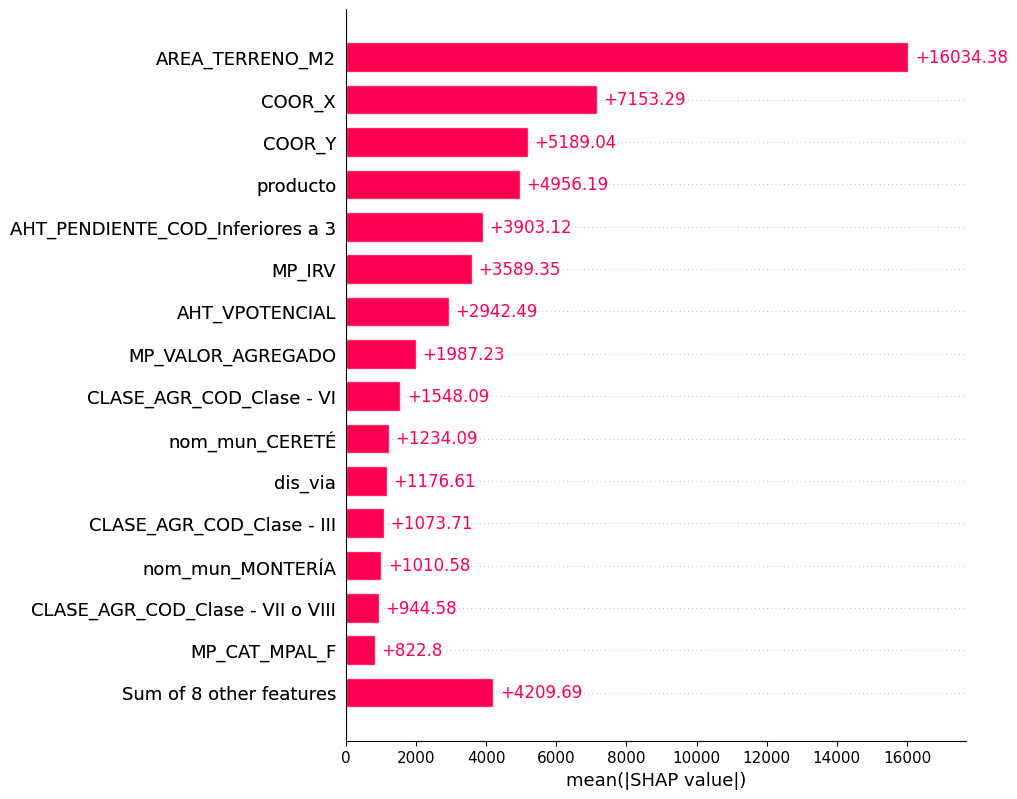

In [11]:
explainer = shap.TreeExplainer(xgb_model_fin, feature_perturbation='interventional')
shap_values = explainer.shap_values(X_train, approximate=True)
vals= np.abs(shap_values).mean(0)

feature_importance_fin = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance_fin.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
# feature_importance_fin.head(25)

# feature_importance_fin_fin=feature_importance_fin[feature_importance_fin['feature_importance_vals']>0.04]['col_name'].to_list()
# print(feature_importance_fin.head(50))
# feature_importance_fin
# print(feature_importance_fin_fin, len(feature_importance_fin_fin))
print(feature_importance_fin)
shap_values2 = explainer(X_train)
import matplotlib.pyplot as plt

shap.plots.bar(shap_values2, max_display=16)

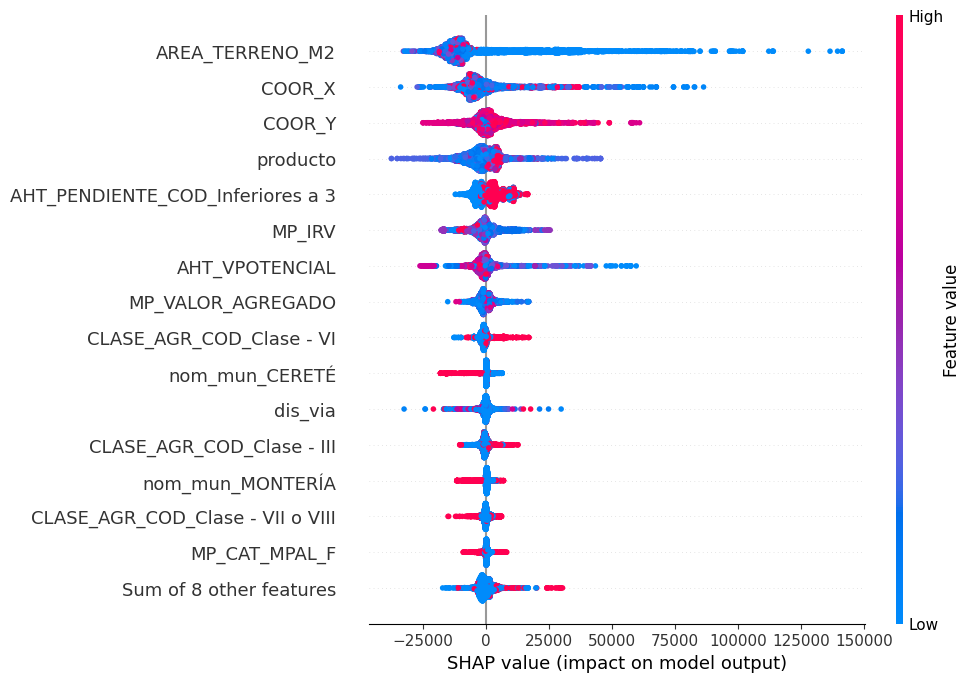

In [10]:
shap.plots.beeswarm(shap_values2, max_display=16)
plt.show()

In [16]:
final_vars = ['AREA_TERRENO_M2',
 'COOR_X',
 'COOR_Y',
 'MP_IRV',
 'producto',
 'AHT_PENDIENTE_COD_Inferiores a 3',
 'AHT_VPOTENCIAL',
 'MP_VALOR_AGREGADO',
 'dis_via',
 'nom_mun_MONTERÍA',
 'nom_mun_CERETÉ',
 'CLASE_AGR_COD_Clase - VI',
 'MP_CAT_MPAL_E',
 'CLASE_AGR_COD_Clase - VII o VIII',
 'MP_CAT_MPAL_F',
 'CLASE_AGR_COD_Clase - III',
 'CLASE_AGR_COD_Clase - IV',
 "VALOR_M2_TERRENO"]


base_modelo_v4 = base_modelo_v3[final_vars]
df_train, df_test = train_test_split(base_modelo_v4, test_size = .2, random_state = 123) #, stratify = base_modelo_3_v3[['DEPARTAMENTO']]

cols = list(base_modelo_v4.columns)
#cols = [x for x in cols if x != "DEPARTAMENTO"]

df_train.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)    
# df_test.drop(["DEPARTAMENTO"], axis = 1, inplace = True)
# df_train.drop(["DEPARTAMENTO"], axis = 1, inplace = True)


for k, i in enumerate(cols):
    df_test[i] = df_test[i].astype('float')
    df_train[i] = df_train[i].astype('float')

df_train = df_train.fillna(df_train.mean())
df_test = df_test.fillna(df_train.mean())

In [17]:

df_train_v2 = df_train.copy()
df_test_v2 = df_test.copy()    
print(df_train.shape)
print(df_test.shape)

df_train_v2 = df_train_v2[df_train_v2["VALOR_M2_TERRENO"] <= 10000000]
df_test_v2 = df_test_v2[df_test_v2["VALOR_M2_TERRENO"] <= 10000000]

print(df_train_v2.shape)
print(df_test_v2.shape)


X_train = df_train_v2.drop(["VALOR_M2_TERRENO"], axis = 1)
y_train = df_train_v2[['VALOR_M2_TERRENO']]
X_test = df_test_v2.drop(["VALOR_M2_TERRENO"], axis = 1)
y_test = df_test_v2[['VALOR_M2_TERRENO']]
interq = 15

xgb_model_fin = xgb.XGBRegressor(colsample_bytree = 0.4,
                                    gamma = 300,
                                    learning_rate = 1,
                                    max_depth = 8,
                                    n_estimators = 200,
                                    subsample = 0.9,
                                    reg_alpha = 200,
                                    reg_lambda = 200,
                                    n_jobs = 1,
                                    random_state = 123
                                    )
xgb_model_fin.fit(X_train, y_train)

y_predict_train = xgb_model_fin.predict(X_train)
#print("Aquí es")
# Assuming y_pred and y_true are your predicted and actual values

differences = [real - predicted for real, predicted in zip(y_train.values, y_predict_train)]
residuals = np.array([float(x) for x in differences])
#residuals = y_train.values - y_predict_train
#print("Aquí es 2")
# Calculate the median and interquartile range of residuals
median_residual = np.median(residuals)
iqr_residual = np.percentile(residuals, 75) - np.percentile(residuals, 25)

# Set a threshold for outliers (e.g., 3 times the IQR)
threshold = interq * iqr_residual

# Create a boolean variable for outliers
outliers = (residuals > threshold) | (residuals < (-threshold))

X_train_v2 = X_train[~outliers]
y_train_v2 = y_train[~outliers]

xgb_model_fin.fit(X_train_v2, y_train_v2)

y_predict_test = xgb_model_fin.predict(X_test)

# Assuming y_pred and y_true are your predicted and actual values
differences = [real - predicted for real, predicted in zip(y_test.values, y_predict_test)]
residuals = np.array([float(x) for x in differences])
# residuals = y_test.values - 

# # Calculate the median and interquartile range of residuals
# median_residual = np.median(residuals)
# iqr_residual = np.percentile(residuals, 75) - np.percentile(residuals, 25)

# # Set a threshold for outliers (e.g., 3 times the IQR)
# threshold = 3 * iqr_residual


# Create a boolean variable for outliers
#outliers = (residuals > median_residual + threshold) | (residuals < median_residual - threshold)
outliers = (residuals >  threshold) | (residuals < (-threshold))

X_test_v2 = X_test[~outliers]
y_test_v2 = y_test[~outliers]

y_predict_train_v2 = xgb_model_fin.predict(X_train_v2)
y_predict_test_v2 = xgb_model_fin.predict(X_test_v2)    

#y_train_pred = xgb_model_fin.predict(x_train)
mse_train = np.round(mean_squared_error(y_train_v2, y_predict_train_v2), 4)
mae_train = np.round(mean_absolute_error(y_train_v2, y_predict_train_v2), 4)
r2_train = np.round(r2_score(y_train_v2, y_predict_train_v2), 4)

### medidas sobre el test
#y_val_pred = xgb_model_fin.predict(X_test)
mse_test = np.round(mean_squared_error(y_test, y_predict_test), 4)
mae_test = np.round(mean_absolute_error(y_test, y_predict_test), 4)
r2_test = np.round(r2_score(y_test, y_predict_test), 4)

mse_test_v2 = np.round(mean_squared_error(y_test_v2, y_predict_test_v2), 4)
mae_test_v2 = np.round(mean_absolute_error(y_test_v2, y_predict_test_v2), 4)
r2_test_v2 = np.round(r2_score(y_test_v2, y_predict_test_v2), 4)

(6859, 18)
(1715, 18)
(6859, 18)
(1715, 18)


Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


### Métricas finales para presentar

In [25]:
pd.options.display.float_format = '{:.2f}'.format

pd.DataFrame({"Muestra": ["Entrenamiento", "Prueba"],
#"RMSE" : [np.sqrt(mse_train), np.sqrt(mse_test_v2)],
"MAE" : [mae_train, mae_test_v2],
"R_squared" : [r2_train, r2_test_v2]})

Muestra      MAE  R_squared
0  Entrenamiento  7643.37       0.89
1         Prueba 10555.20       0.81

### Entrenamiento del modelo final para generar la predicción

In [27]:
y_fin = pd.concat([y_train_v2, y_test_v2], axis = 0)
X_fin = pd.concat([X_train_v2, X_test_v2], axis = 0)

In [16]:
print(X_train_v2.shape)
print(X_test_v2.shape)
print(X_fin.shape)

(6770, 23)
(1664, 23)
(8434, 23)


In [33]:
xgb_model_fin_v2 = xgb.XGBRegressor(colsample_bytree = 0.4,
                                    gamma = 300,
                                    learning_rate = 1,
                                    max_depth = 8,
                                    n_estimators = 200,
                                    subsample = 0.9,
                                    reg_alpha = 200,
                                    reg_lambda = 200,
                                    n_jobs = 1,
                                    random_state = 123
                                    )
xgb_model_fin_v2.fit(X_fin, y_fin)

#y_predict_train = xgb_model_fin.predict(X_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=300, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=1,
             num_parallel_tree=None, random_state=123, ...)

[03:29:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


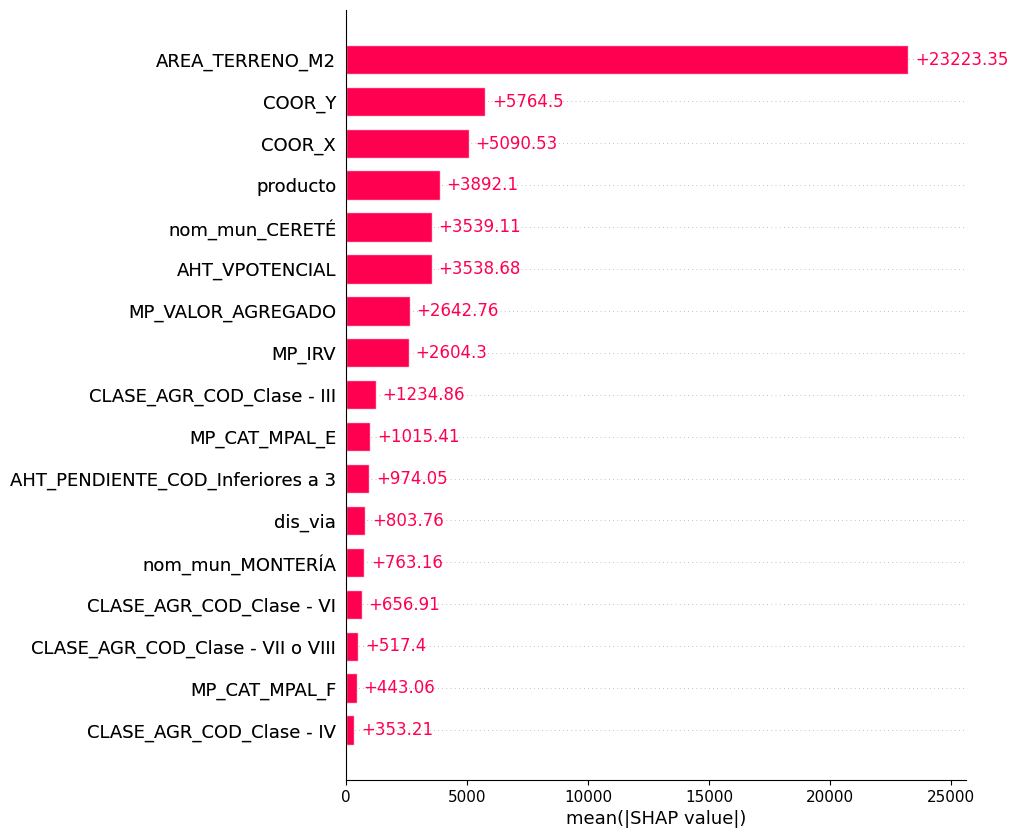

In [39]:
explainer = shap.TreeExplainer(xgb_model_fin_v2, feature_perturbation='interventional')
shap_values = explainer.shap_values(X_fin, check_additivity=False)
# vals= np.abs(shap_values).mean(0)
# feature_importance_fin = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
# feature_importance_fin.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
# feature_importance_fin.head(25)

# feature_importance_fin_fin=feature_importance_fin[feature_importance_fin['feature_importance_vals']>0.04]['col_name'].to_list()
# print(feature_importance_fin.head(50))
# feature_importance_fin
# print(feature_importance_fin_fin, len(feature_importance_fin_fin))
# print(feature_importance_fin)
shap_values2 = explainer(X_fin, check_additivity=False)
import matplotlib.pyplot as plt

shap.plots.bar(shap_values2, max_display=17)

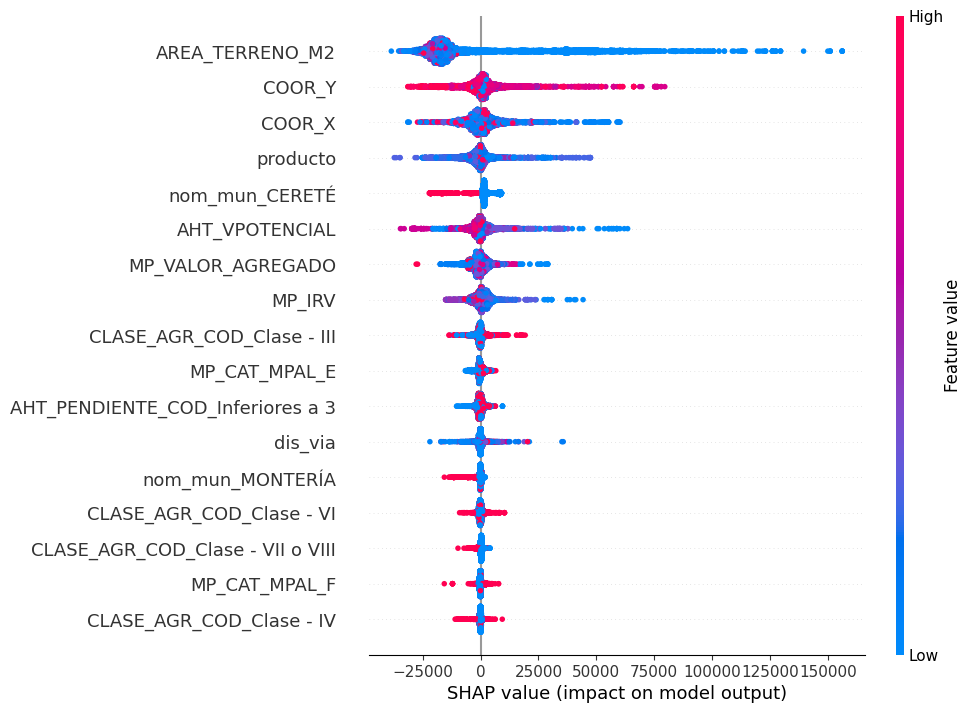

In [40]:
shap.plots.beeswarm(shap_values2, max_display=17)
plt.show()

In [41]:
# Save the model using pickle
with open("../output/MODELO_XGB_ARTICULO_49.pkl", "wb") as file:
    pickle.dump(xgb_model_fin_v2, file)

In [42]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
